프로젝트 명 : 레드벨벳 멤버 얼굴 분류 학습

> 모델 : cnn

> 학습 환경 : 구글 코랩 Google COLAB




>참고 코드 : https://github.com/skywalker023/deep_iab


> k-fold 추가 :https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/


>  각 데이터 폴드 세트에 대해서 나온 검증 결과들을 평균내어 최종적인 검증 결과를 도출하는 것











필요한 모듈을 불러온다.


In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import os
import shutil
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


train_path 에는 멤버별 폴더가 있고, 각각의 폴더에는 얼굴만 crop 된 이미지가 준비 되어 있다.

이미지 준비 방법
  1. 구글에서 각 멤버별 사진을 클롤링 한다.
  2. OPEN CV 를 사용하여 인물의 얼굴만 CROP 한다.

In [13]:
train_path =  '/content/croppeddata'

CNN 모델 설계


In [14]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 6, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.conv3 = nn.Conv2d(6, 6, 3, stride=1, padding=1)                 
 
        self.fc1 = nn.Linear(32*32*6,500 )
        self.fc2 = nn.Linear(500,250 )
        self.fc3 = nn.Linear(250,5 )

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu(x)
                   
        x = x.view(-1,32*32*6)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x
    

K FOLD 를 하기위해 모듈을 불러온다.


In [15]:
from sklearn.model_selection import KFold
kfold =KFold(n_splits=10, shuffle=True)



torchvision.datasets.ImageFolder() 함수를 사용하여 전체 데이터에 대한 DATA SET 을 만든다.

> 각 K FOLD iteration 이 반복될 때 마다, train, test 데이터 set을 만들기 편하다.

> torch.utils.data.Subset() 함수 사용



In [16]:
allimage =torchvision.datasets.ImageFolder('croppeddata')

In [17]:
kfold_iter = 0
loss_history = [] 
result =[0,0] # 평균 Accuracy 를 계산하기 위함.[누적 Accuracy, K]

for train_index, test_index in kfold.split(allimage): 
  kfold_iter += 1

  # k-fold 는 모델 함수, loss 함수, 최적화 함수를 매 k iteration 마다 새로 선언해야 한다.
  # 이전 k 학습의 결과와 무관한 학습을 진행하기 때문이다.

  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.0001)
  
  train = torch.utils.data.Subset(allimage,train_index)
  train.dataset.transform = transforms.Compose([
                                                transforms.Resize((128,128)),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,0.5,0.5),(0.3,0.3,0.3)),
                                                transforms.ColorJitter(brightness=(0.2, 3))])

  test = torch.utils.data.Subset(allimage,test_index)
  test.dataset.transform = transforms.Compose([
                                                transforms.Resize((128,128)),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,0.5,0.5),(0.3,0.3,0.3))
                                                ])

  trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=True,num_workers=2)
    
  for epoch in range(10):

    running_loss = 0.0
    len_data = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()
        len_data +=len(labels)
    
    loss_history.append(running_loss/len_data)
    
    print("kfold_iter : ", kfold_iter,"\n","epoch : ",epoch, "\n",'loss : ',running_loss/len_data )

    # 모델 저장하기
    save_path = f'./model-fold-{kfold_iter}.pth'
    torch.save(net.state_dict(), save_path)

  # 테스트 데이터로 평가하기
  correct = 0
  total = 0
  with torch.no_grad():
    for i, data in enumerate(testloader):
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('\n')    
  print('테스트 이미지에 대한 정답률: %d %%' % (100 * correct / total))
  print('\n')

  result[0]+=100 * correct / total
  result[1]+=1
            
print('학습 끝!')

kfold_iter :  1 
 epoch :  0 
 loss :  0.05092156027990674
kfold_iter :  1 
 epoch :  1 
 loss :  0.05053620426743119
kfold_iter :  1 
 epoch :  2 
 loss :  0.050346975919430846
kfold_iter :  1 
 epoch :  3 
 loss :  0.04996797268983548
kfold_iter :  1 
 epoch :  4 
 loss :  0.04959227578349845
kfold_iter :  1 
 epoch :  5 
 loss :  0.0489097619182849
kfold_iter :  1 
 epoch :  6 
 loss :  0.04867115380272033
kfold_iter :  1 
 epoch :  7 
 loss :  0.04784921994284978
kfold_iter :  1 
 epoch :  8 
 loss :  0.04650286928055778
kfold_iter :  1 
 epoch :  9 
 loss :  0.04541952332491597


테스트 이미지에 대한 정답률: 21 %


kfold_iter :  2 
 epoch :  0 
 loss :  0.051151390428896305
kfold_iter :  2 
 epoch :  1 
 loss :  0.050755851798587374
kfold_iter :  2 
 epoch :  2 
 loss :  0.05042848416737148
kfold_iter :  2 
 epoch :  3 
 loss :  0.050104239314952226
kfold_iter :  2 
 epoch :  4 
 loss :  0.04971405438014439
kfold_iter :  2 
 epoch :  5 
 loss :  0.04886220371912396
kfold_iter :  2 
 epoch :  

In [18]:
print('K-FOLD CROSS VALIDATION RESULTS')
print('--------------------------------')
print(f'평균 정답률: {result[0]/result[1]} %')

K-FOLD CROSS VALIDATION RESULTS
--------------------------------
평균 정답률: 31.90476190476191 %


In [19]:
def imshow(img):
  img = img/2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img,(1,2,0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wendy seulgi  yeri wendy wendy  yeri irene
irene   joy   joy irene irene   joy seulgi


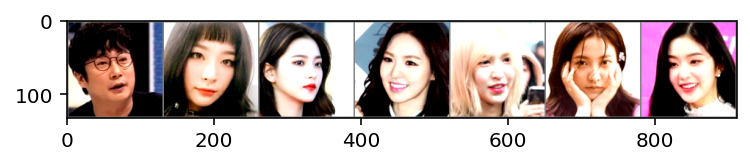

In [20]:
classes = ['irene','joy','seulgi','wendy','yeri' ]
testloader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=True,num_workers=2)

predicted_all = []
label_all = []
image_all = []

for i, data in enumerate(testloader):
  images, labels = data
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 1)
  
  predicted_all += predicted 
  label_all += labels
  image_all += images


howmany = len(image_all)//6

imshow(torchvision.utils.make_grid(image_all[:howmany],nrow=howmany ))
  
print(" ".join("%5s"%classes[label_all[j]] for j in range(howmany )))
print(" ".join("%5s"%classes[predicted_all[j]] for j in range(howmany )))
    



[0.05092156027990674, 0.05053620426743119, 0.050346975919430846, 0.04996797268983548, 0.04959227578349845, 0.0489097619182849, 0.04867115380272033, 0.04784921994284978, 0.04650286928055778, 0.04541952332491597, 0.051151390428896305, 0.050755851798587374, 0.05042848416737148, 0.050104239314952226, 0.04971405438014439, 0.04886220371912396, 0.04764153780760588, 0.046184542002501314, 0.04464129669956429, 0.04316244838099, 0.05097846820871666, 0.0504887719002981, 0.04978925494289903, 0.048939062174035125, 0.04743203095027378, 0.046077120871770946, 0.044455625392772535, 0.04216364546427651, 0.04063889084669648, 0.03898739972442546, 0.05091972483528985, 0.0504611402592331, 0.04997221313456379, 0.049411527378849254, 0.048485248177139846, 0.0474146806373798, 0.04607652955585056, 0.044658881331247, 0.04263689120610555, 0.039902006507550596, 0.05079782103735303, 0.050483871704686885, 0.05029178927184413, 0.049974514693810194, 0.0492912698044348, 0.04840540192114613, 0.047179856628337236, 0.045807

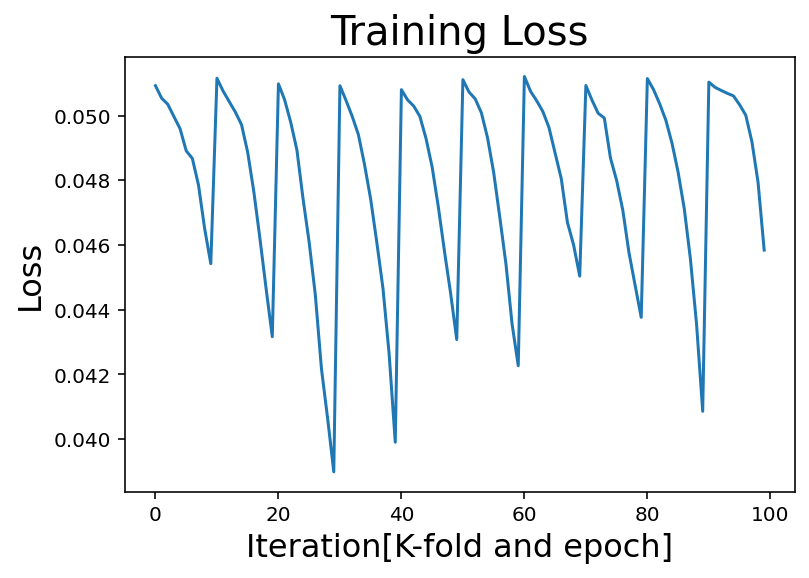

In [21]:
print(loss_history)
plt.plot(loss_history) 
plt.title('Training Loss', fontsize=20) 
plt.xlabel('Iteration[K-fold and epoch]',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()